# HR Analytics: Job Change of Data Scientists - Data Exploration

## Dataset Overview
This dataset contains information about candidates who completed training courses. The goal is to predict whether a candidate is looking for a job change or will continue working for the company.

**Target Variable:**
- `target`: 0 = Not looking for job change, 1 = Looking for a job change

**Features:**
- `enrollee_id`: Unique ID for candidate
- `city`: City code
- `city_development_index`: Development index of the city (scaled)
- `gender`: Gender of candidate
- `relevent_experience`: Relevant experience of candidate
- `enrolled_university`: Type of University course enrolled if any
- `education_level`: Education level of candidate
- `major_discipline`: Education major discipline of candidate
- `experience`: Candidate total experience in years
- `company_size`: Number of employees in current employer's company
- `company_type`: Type of current employer
- `last_new_job`: Difference in years between previous job and current job
- `training_hours`: Training hours completed

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import sys

# Add src folder to path
sys.path.append('../src')
from visualization import *

warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

In [2]:
def load_csv_data(filepath):
    data = np.genfromtxt(filepath, delimiter=',', skip_header=1, dtype=str, encoding='utf-8')
    with open(filepath, 'r', encoding='utf-8') as file:
        headers = file.readline().strip().split(',')
    
    return data, headers

train_data, train_headers = load_csv_data('../data/raw/aug_train.csv')
test_data, test_headers = load_csv_data('../data/raw/aug_test.csv')

print(f"Training data shape: {train_data.shape}")
print(f"Test data shape: {test_data.shape}")
print(f"Column ({len(train_headers)} columns)")


Training data shape: (19158, 14)
Test data shape: (2129, 13)
Column (14 columns)


# 1. EDA - Exploratory Data Analysis

## 1.1 Basic Information

In [3]:
print("First 5 rows of the training data:")
print(f"{'Index':<8}", end='')
for header in train_headers:
    print(f"{header:<20}", end='')
print()
print("="*120)

for i in range(min(5, len(train_data))):
    print(f"{i:<8}", end='')
    for j in range(len(train_headers)):
        value = train_data[i, j] if train_data[i, j] else 'NaN'
        print(f"{str(value):<20}", end='')
    print()



First 5 rows of the training data:
Index   enrollee_id         city                city_development_indexgender              relevent_experience enrolled_university education_level     major_discipline    experience          company_size        company_type        last_new_job        training_hours      target              
0       8949                city_103            0.92                Male                Has relevent experienceno_enrollment       Graduate            STEM                >20                 NaN                 NaN                 1                   36                  1.0                 
1       29725               city_40             0.7759999999999999  Male                No relevent experienceno_enrollment       Graduate            STEM                15                  50-99               Pvt Ltd             >4                  47                  0.0                 
2       11561               city_21             0.624               NaN                 No 

In [4]:
# Helper functions 
def get_column_by_name(data, headers, column_name):
    idx = headers.index(column_name)
    return data[:, idx]

def convert_to_numeric(column):
    numeric_col = []
    for val in column:
        try:
            if val == '' or val is None:
                numeric_col.append(np.nan)
            else:
                numeric_col.append(float(val))
        except (ValueError, TypeError):
            numeric_col.append(np.nan)
    return np.array(numeric_col)

def describe_numeric_column(column, column_name):
    numeric_data = convert_to_numeric(column)
    valid_data = numeric_data[~np.isnan(numeric_data)]
    
    if len(valid_data) == 0:
        return None
    
    stats = {
        'count': len(valid_data),
        'mean': np.mean(valid_data),
        'std': np.std(valid_data, ddof=1),
        'min': np.min(valid_data),
        '25%': np.percentile(valid_data, 25),
        '50%': np.percentile(valid_data, 50),
        '75%': np.percentile(valid_data, 75),
        'max': np.max(valid_data)
    }
    return stats

numeric_columns = ['city_development_index', 'training_hours', 'target'] # Cột dữ liệu số

print("Statistical Summary - Numerical Features:")
print("="*100)
for col_name in numeric_columns:
    col_data = get_column_by_name(train_data, train_headers, col_name)
    stats = describe_numeric_column(col_data, col_name)
    
    if stats:
        print(f"\n{col_name}:")
        print(f"  Count:  {stats['count']:>10.0f}")
        print(f"  Mean:   {stats['mean']:>10.4f}")
        print(f"  Std:    {stats['std']:>10.4f}")
        print(f"  Min:    {stats['min']:>10.4f}")
        print(f"  25%:    {stats['25%']:>10.4f}")
        print(f"  50%:    {stats['50%']:>10.4f}")
        print(f"  75%:    {stats['75%']:>10.4f}")
        print(f"  Max:    {stats['max']:>10.4f}")

Statistical Summary - Numerical Features:

city_development_index:
  Count:       19158
  Mean:       0.8288
  Std:        0.1234
  Min:        0.4480
  25%:        0.7400
  50%:        0.9030
  75%:        0.9200
  Max:        0.9490

training_hours:
  Count:       19158
  Mean:      65.3669
  Std:       60.0585
  Min:        1.0000
  25%:       23.0000
  50%:       47.0000
  75%:       88.0000
  Max:      336.0000

target:
  Count:       19158
  Mean:       0.2493
  Std:        0.4326
  Min:        0.0000
  25%:        0.0000
  50%:        0.0000
  75%:        0.0000
  Max:        1.0000


In [5]:
def get_unique_values(column):
    cleaned = np.array([val if val != '' else None for val in column])
    unique_vals = []
    for val in cleaned:
        if val not in unique_vals:
            unique_vals.append(val)
    return [v for v in unique_vals if v is not None]

print("Unique Values and Value Ranges:")
print("="*80)

for i, col_name in enumerate(train_headers):
    col_data = train_data[:, i]
    unique_vals = get_unique_values(col_data)
    n_unique = len(unique_vals)
    
    print(f"\n{col_name}:")
    print(f"  - Column index: {i}")
    print(f"  - Unique values: {n_unique}")
    
    # Try to convert to numeric
    numeric_data = convert_to_numeric(col_data)
    is_numeric = not np.all(np.isnan(numeric_data))
    
    if is_numeric and n_unique <= 20:
        valid_nums = numeric_data[~np.isnan(numeric_data)]
        print(f"  - Values: {sorted(set(valid_nums))}")
        print(f"  - Range: [{np.min(valid_nums):.4f}, {np.max(valid_nums):.4f}]")
    elif is_numeric:
        valid_nums = numeric_data[~np.isnan(numeric_data)]
        sample = sorted(set(valid_nums))[:10]
        print(f"  - Sample numeric values: {sample}")
        print(f"  - Range: [{np.min(valid_nums):.4f}, {np.max(valid_nums):.4f}]")
    else:
        if n_unique <= 20:
            print(f"  - Values: {sorted(unique_vals)}")
        else:
            print(f"  - Sample values: {unique_vals[:10]}")

Unique Values and Value Ranges:

enrollee_id:
  - Column index: 0
  - Unique values: 19158
  - Sample numeric values: [1.0, 2.0, 4.0, 5.0, 7.0, 8.0, 9.0, 10.0, 11.0, 13.0]
  - Range: [1.0000, 33380.0000]

city:
  - Column index: 1
  - Unique values: 123
  - Sample values: ['city_103', 'city_40', 'city_21', 'city_115', 'city_162', 'city_176', 'city_160', 'city_46', 'city_61', 'city_114']

city_development_index:
  - Column index: 2
  - Unique values: 93
  - Sample numeric values: [0.44799999999999995, 0.479, 0.48700000000000004, 0.493, 0.512, 0.516, 0.518, 0.527, 0.55, 0.555]
  - Range: [0.4480, 0.9490]

gender:
  - Column index: 3
  - Unique values: 3
  - Values: ['Female', 'Male', 'Other']

relevent_experience:
  - Column index: 4
  - Unique values: 2
  - Values: ['Has relevent experience', 'No relevent experience']

enrolled_university:
  - Column index: 5
  - Unique values: 3
  - Values: ['Full time course', 'Part time course', 'no_enrollment']

education_level:
  - Column index: 6


## 1.2 Target Variable Distribution

Target Variable Distribution:
0 (Not looking for job change): 14,381 (75.07%)
1 (Looking for job change): 4,777 (24.93%)

Class Imbalance Ratio: 3.01:1


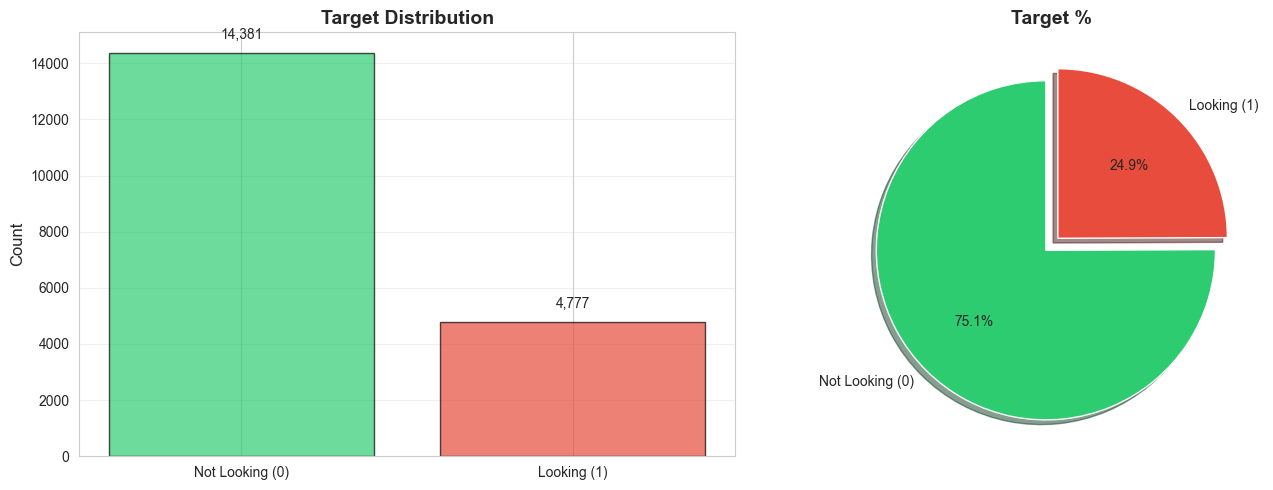

In [6]:
# Target variable distribution 
target_col = get_column_by_name(train_data, train_headers, 'target')
target_numeric = convert_to_numeric(target_col)

# Count
unique_targets, counts = np.unique(target_numeric[~np.isnan(target_numeric)], return_counts=True)
total = len(target_numeric[~np.isnan(target_numeric)])

target_counts = {int(unique_targets[i]): counts[i] for i in range(len(unique_targets))}
target_pct = {int(unique_targets[i]): (counts[i] / total * 100) for i in range(len(unique_targets))}

print("Target Variable Distribution:")
print("="*50)
print(f"0 (Not looking for job change): {target_counts[0]:,} ({target_pct[0]:.2f}%)")
print(f"1 (Looking for job change): {target_counts[1]:,} ({target_pct[1]:.2f}%)")
print(f"\nClass Imbalance Ratio: {target_counts[0]/target_counts[1]:.2f}:1")

# Visualization
plot_target_distribution(target_counts, target_pct)

1. Số lượng ứng viên muốn tìm công việc mới chiếm khoảng 25% so với tổng số ứng viên và phần lớn là những ứng viên không muốn tìm công việc mới, mất cân bằng nên ta có thể cân nhắc sử dụng phương pháp training có trọng số lên nhóm thiểu số để đảm bảo khả năng ảnh hưởng đến Loss

# 2. Missing Values Analysis

## 2.1 Identifying Missing Values

In [7]:
def count_missing(column):
    return np.sum(np.array([1 if (val == '' or val is None) else 0 for val in column]))

missing_info = []
total_rows = len(train_data)

for i, col_name in enumerate(train_headers):
    col_data = train_data[:, i]
    missing_count = count_missing(col_data)
    missing_pct = (missing_count / total_rows) * 100
    
    missing_info.append({
        'column': col_name,
        'missing_count': missing_count,
        'missing_pct': missing_pct
    })

# Sort by missing percentage
missing_info_sorted = sorted(missing_info, key=lambda x: x['missing_pct'], reverse=True)
print(f"{'Column':<25} {'Missing Count':<15} {'Missing %':<15}")
print("="*80)

for info in missing_info_sorted:
    print(f"{info['column']:<25} {info['missing_count']:<15} {info['missing_pct']:<15.2f}")

total_missing = sum([info['missing_count'] for info in missing_info])
cols_with_missing = sum([1 for info in missing_info if info['missing_count'] > 0])


Column                    Missing Count   Missing %      
company_type              6140            32.05          
company_size              5938            30.99          
gender                    4508            23.53          
major_discipline          2813            14.68          
education_level           460             2.40           
last_new_job              423             2.21           
enrolled_university       386             2.01           
experience                65              0.34           
enrollee_id               0               0.00           
city                      0               0.00           
city_development_index    0               0.00           
relevent_experience       0               0.00           
training_hours            0               0.00           
target                    0               0.00           


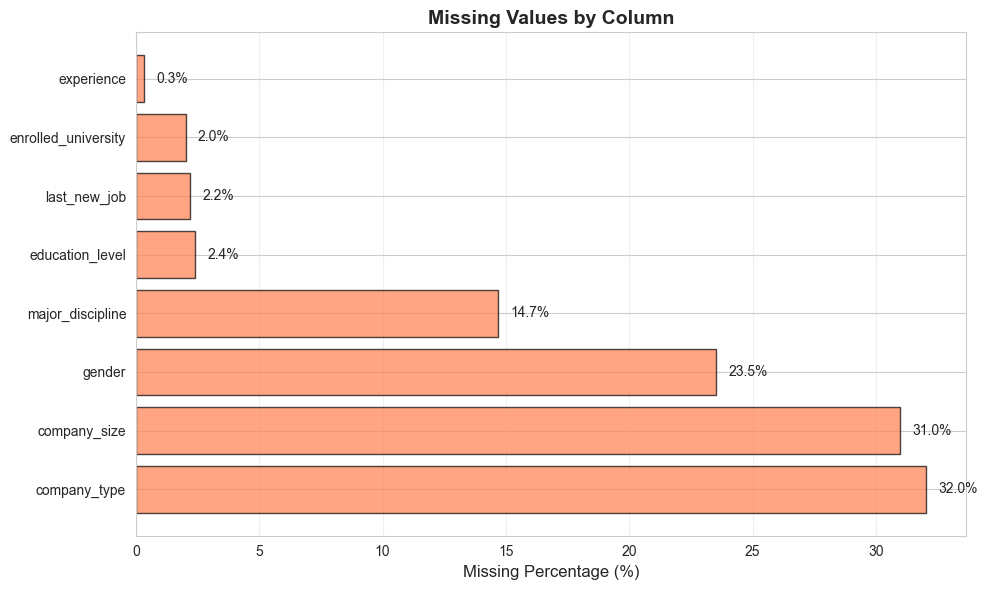

In [8]:
# Filter columns with missing values
missing_cols_data = [(info['column'], info['missing_pct']) 
                     for info in missing_info_sorted if info['missing_pct'] > 0]

if len(missing_cols_data) > 0:
    columns, percentages = zip(*missing_cols_data)
    
    fig, ax = plt.subplots(figsize=(10, 6))
    y_pos = np.arange(len(columns))
    
    ax.barh(y_pos, percentages, color='coral', edgecolor='black', alpha=0.7)
    ax.set_yticks(y_pos)
    ax.set_yticklabels(columns)
    ax.set_xlabel('Missing Percentage (%)', fontsize=12)
    ax.set_title('Missing Values by Column', fontsize=14, fontweight='bold')
    ax.grid(axis='x', alpha=0.3)
    
    for i, pct in enumerate(percentages):
        ax.text(pct + 0.5, i, f'{pct:.1f}%', va='center', fontsize=10)
    
    plt.tight_layout()
    plt.show()
else:
    print("No missing values found in the dataset.")

## 2.2 Missing Value Handling
### Chiến lược fill NaN
- **Nhóm thiếu nhiều (>20%)**: Điền bằng giá trị 'Unknown'
- **Nhóm thiếu ít (<15%)**: Điền bằng giá trị phổ biến nhất (Mode)

In [9]:
def get_mode(column):
    # Lấy ra giá trị xuất hiện nhiều nhất trong 1 cột
    values = [v for v in column if v != '' and v is not None]
    if len(values) == 0:
        return None

    unique_vals, counts = np.unique(values, return_counts=True)
    mode_idx = np.argmax(counts)
    return unique_vals[mode_idx]

train_data= train_data.copy()

print("Handling Missing Values:")
print("="*80)

for info in missing_info_sorted:
    col_name = info['column']
    missing_pct = info['missing_pct']
    
    if missing_pct > 0 and col_name != 'enrollee_id':  
        col_idx = train_headers.index(col_name)
        col_data = train_data[:, col_idx]
        
        missing_before = count_missing(col_data)
        
        if missing_pct > 20:
            # Nhóm thiếu nhiều: Điền 'Unknown'
            fill_value = 'Unknown'
            strategy = "Fill with 'Unknown' (>20% missing)"
        elif missing_pct < 15:
            # Nhóm thiếu ít: Điền bằng Mode
            fill_value = get_mode(col_data)
            if fill_value is None:
                fill_value = 'Unknown'
            strategy = f"Fill with Mode: '{fill_value}' (<15% missing)"
        else:
            # Khoảng giữa 15-20%
            fill_value = 'Unknown'
            strategy = "Fill with 'Unknown' (15-20% missing)"
        # Fill in
        for i in range(len(col_data)):
            if col_data[i] == '' or col_data[i] is None:
                train_data[i, col_idx] = fill_value
        
        # Count missing after
        missing_after = count_missing(train_data[:, col_idx])
        
        print(f"\n{col_name}:")
        print(f"  Missing %: {missing_pct:.2f}%")
        print(f"  Strategy: {strategy}")
        print(f"  Missing before: {missing_before}")
        print(f"  Missing after: {missing_after}")


Handling Missing Values:

company_type:
  Missing %: 32.05%
  Strategy: Fill with 'Unknown' (>20% missing)
  Missing before: 6140
  Missing after: 0

company_size:
  Missing %: 30.99%
  Strategy: Fill with 'Unknown' (>20% missing)
  Missing before: 5938
  Missing after: 0

gender:
  Missing %: 23.53%
  Strategy: Fill with 'Unknown' (>20% missing)
  Missing before: 4508
  Missing after: 0

major_discipline:
  Missing %: 14.68%
  Strategy: Fill with Mode: 'STEM' (<15% missing)
  Missing before: 2813
  Missing after: 0

education_level:
  Missing %: 2.40%
  Strategy: Fill with Mode: 'Graduate' (<15% missing)
  Missing before: 460
  Missing after: 0

last_new_job:
  Missing %: 2.21%
  Strategy: Fill with Mode: '1' (<15% missing)
  Missing before: 423
  Missing after: 0

enrolled_university:
  Missing %: 2.01%
  Strategy: Fill with Mode: 'no_enrollment' (<15% missing)
  Missing before: 386
  Missing after: 0

experience:
  Missing %: 0.34%
  Strategy: Fill with Mode: '>20' (<15% missing)
  

# 3. Data Exploration Questions & Visualizations


In [10]:
# Helper function for categorical analysis
def analyze_categorical_vs_target(data, headers, cat_col_name, target_col_name='target'):
    cat_col = get_column_by_name(data, headers, cat_col_name)
    target_col = get_column_by_name(data, headers, target_col_name)
    target_numeric = convert_to_numeric(target_col)
    
    unique_cats = get_unique_values(cat_col)
    stats = {}
    for cat in unique_cats:
        mask = np.array([val == cat for val in cat_col])
        targets = target_numeric[mask]
        targets = targets[~np.isnan(targets)]
        
        if len(targets) > 0:
            stats[cat] = {
                'count': len(targets),
                'looking': int(np.sum(targets == 1)),
                'not_looking': int(np.sum(targets == 0)),
                'percentage': float(np.sum(targets == 1) / len(targets) * 100)
            }
    
    return stats


### Question 1: Kinh nghiệm liên quan có ảnh hướng đến quyết định thay đổi công việc như thế nào

Job Change Rate by Relevant Experience:


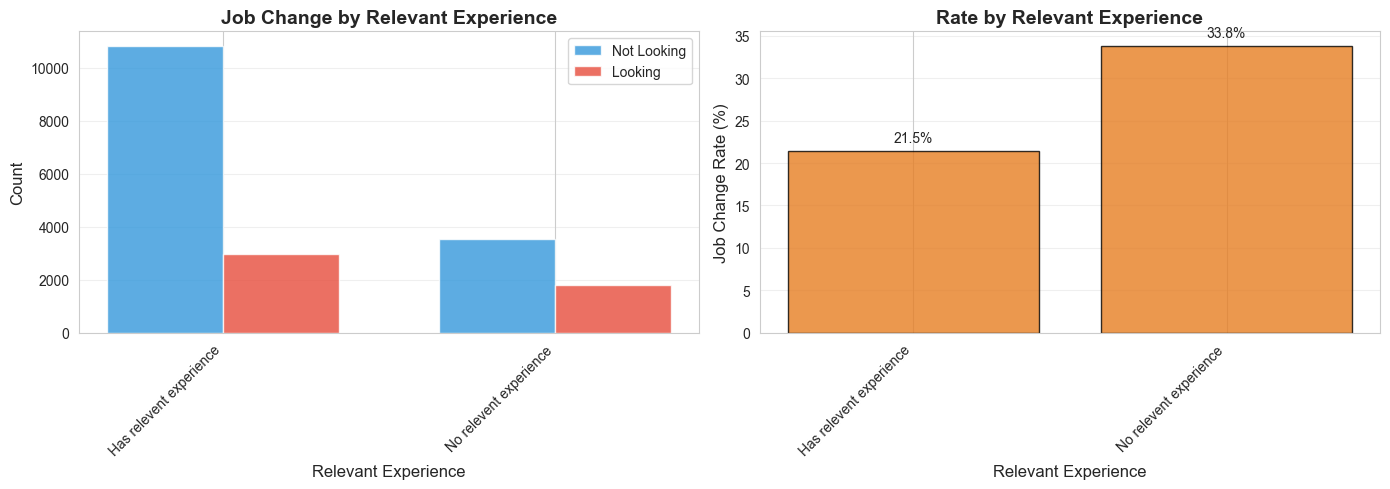

In [11]:
exp_stats = analyze_categorical_vs_target(train_data, train_headers, 'relevent_experience')
print("Job Change Rate by Relevant Experience:")
plot_categorical_vs_target(exp_stats, 'Relevant Experience')


#### Trả lời: 
1. Những nhân viên có kinh nghiệm làm việc liên quan thường sẽ có tỉ lệ số người muốn nhảy việc ít hơn so với những nhân viên không có kinh nghiệm. Những người đã có kinh nghiệm thường đã có vị trí ổn định, mức lương tốt hơn hoặc họ thận trọng hơn trong việc thay đổi môi trường làm việc. Sự gắn bó của họ với công ty hiện tại cao hơn.

## Question 2: Trình độ học thức và ý định chuyển việc có mối liên hệ nào với nhau không?

Job Change Rate by Education Level:


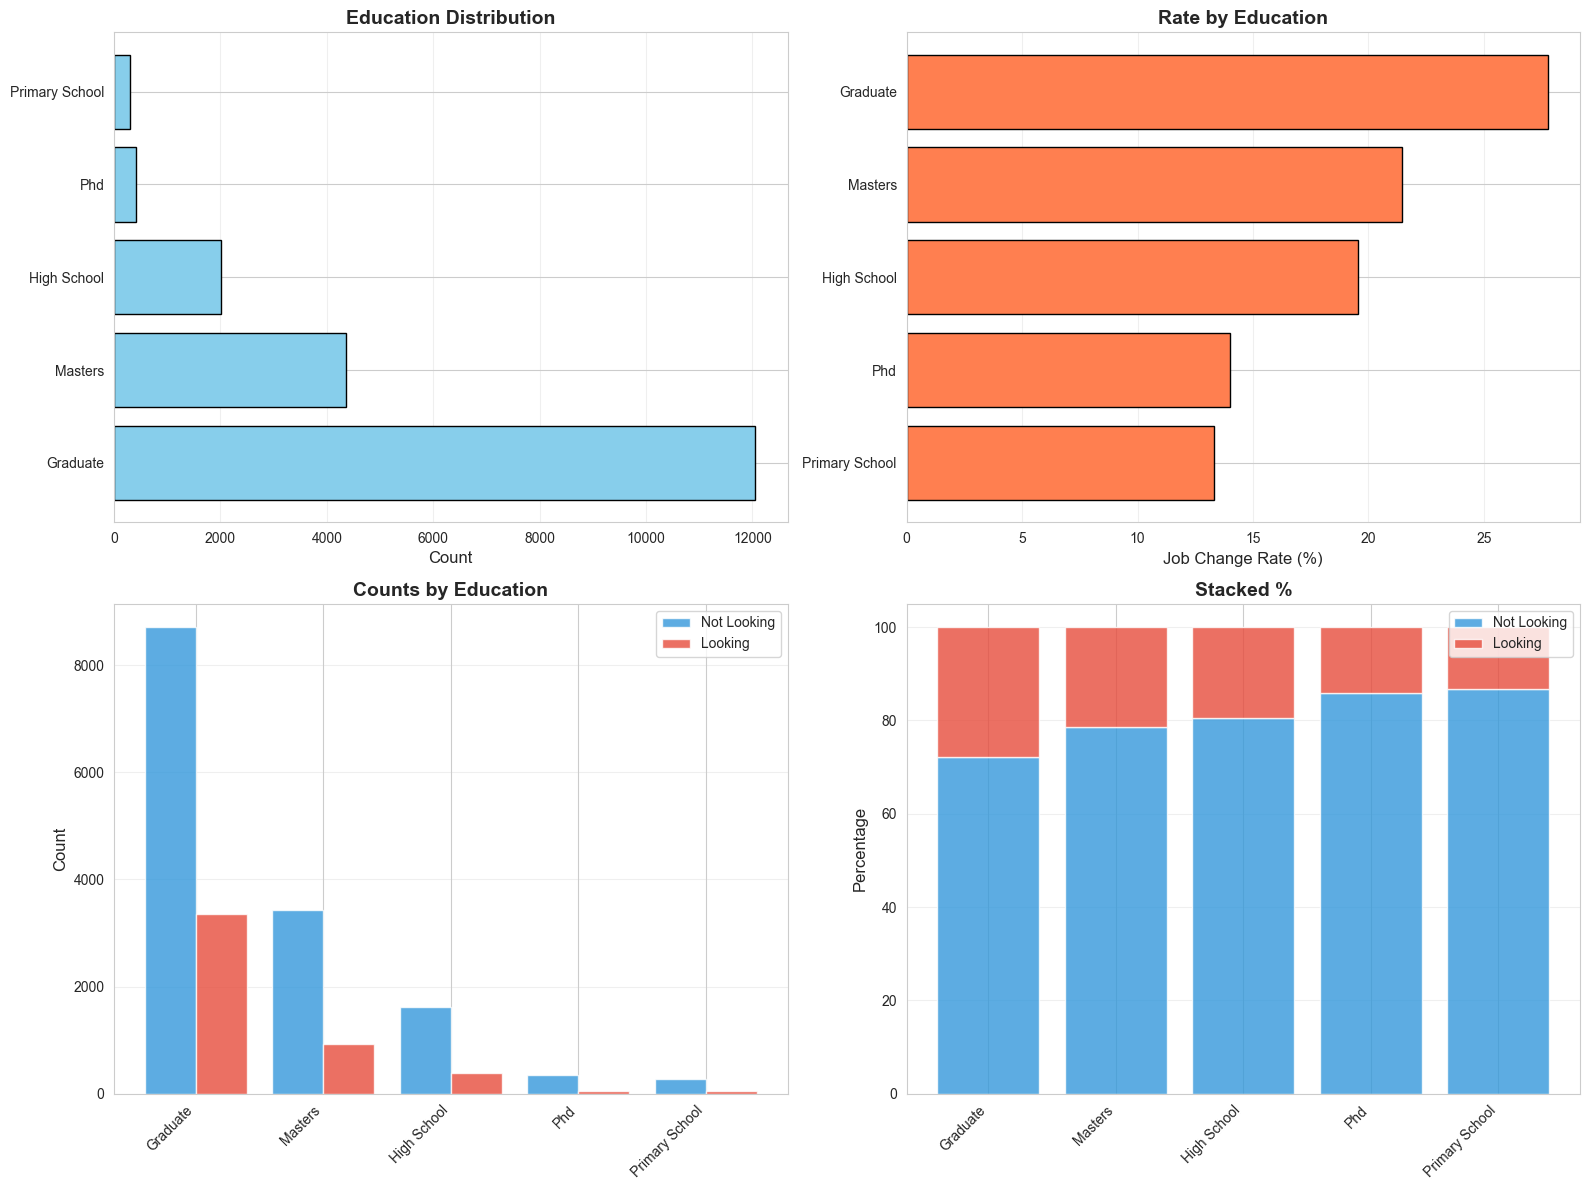

In [12]:
edu_stats = analyze_categorical_vs_target(train_data, train_headers, 'education_level')
edu_sorted = sorted(edu_stats.items(), key=lambda x: x[1]['percentage'], reverse=True)
print("Job Change Rate by Education Level:")
plot_education_analysis(edu_stats)


#### Trả lời: 
1. Phần lớn người là có trình độ tốt nghiệp đại học, hai nhóm nhỏ là PhD và Primary school cũng khá hiếm gặp
2. Nhóm graduate có phần lớn người đang có ý định chuyển việc và ngược lại đối với 2 nhóm là PhD và Primary school -> Có thể nhóm Primary school có suy nghĩ khó tìm được công việc mới còn nhóm PhD sẽ được công ty đãi ngộ cao và cũng không muốn rời
3. Nếu tuyển dụng nhân sự có bằng Tiến sĩ (PhD), khả năng họ gắn bó lâu dài với công ty sẽ cao hơn đáng kể so với các nhóm trình độ khác.
4. Feature này đóng góp khá tốt trong quá trình phân loại

## Question 3: Kinh nghiệm làm việc có ảnh hưởng đến quyết định tìm kiếm công việc mới như thế nào?

Job Change Rate by Years of Experience:


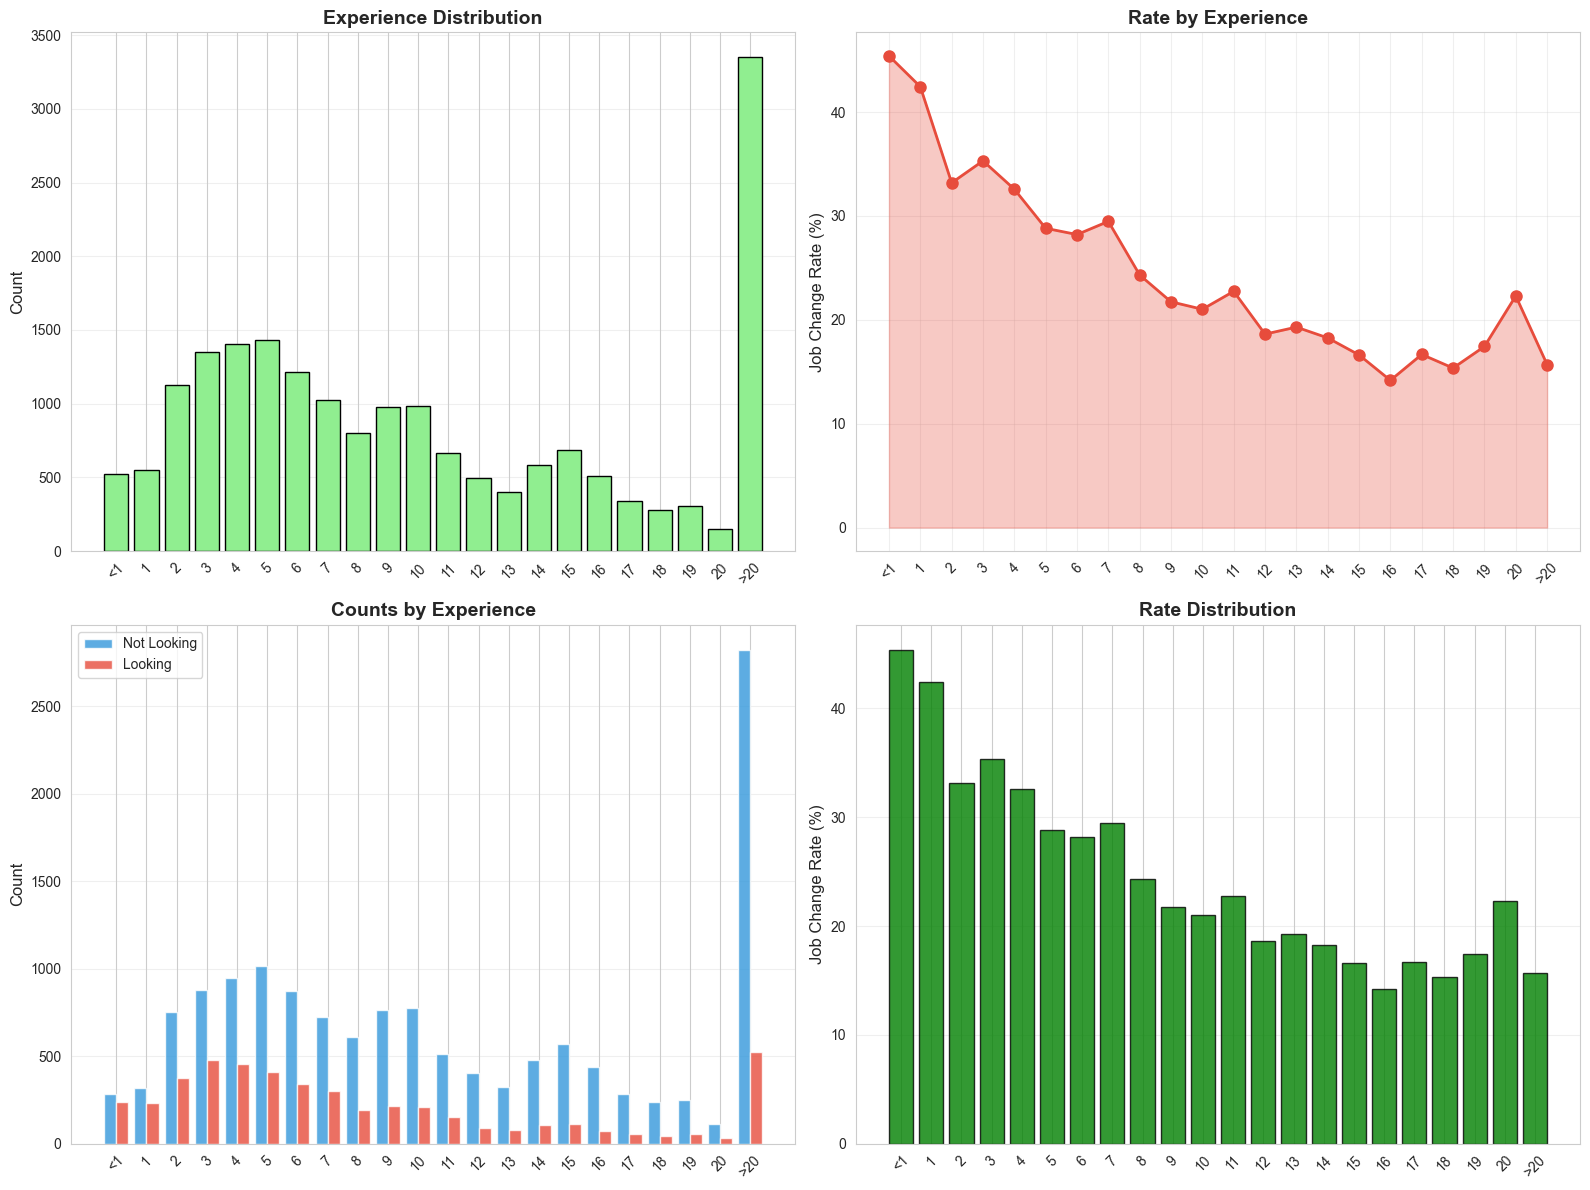

In [13]:
exp_stats = analyze_categorical_vs_target(train_data, train_headers, 'experience')
exp_order = ['<1', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', 
             '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '>20']
exp_sorted = [(exp, exp_stats[exp]) for exp in exp_order if exp in exp_stats]

print("Job Change Rate by Years of Experience:")
plot_experience_analysis(exp_sorted)

#### Trả lời: 
1. Đồ thị trên cho thấy rằng số người có hơn 20 năm kinh nghiệm chiếm đa số.
2. Người có càng nhiều năm kinh nghiệm càng ít muốn chuyển việc, mặc dù có một xu hướng nhỏ những người có 20 năm kinh nghiệm cũng "mong muốn" tìm công việc mới (cũng hợp lý vì có thể vì có những người đã chán với công việc hiện tại)
3. Đáng lưu ý nhất là nhóm Fresher/Junior (1-2 năm kinh nghiệm) có tỷ lệ nhảy việc cao kỷ lục lên đến 45%. Có thể đây là giai đoạn tìm kiếm công việc, công ty thích hợp.
4. Mô hình phân loại sẽ ảnh hưởng khá mạnh mẽ bởi feature này bởi sự phân phối của giá trị target khác biệt rất rõ đối với từng nhóm exp

## Question 4: Chỉ số phát triển của thành phố có ảnh huởng đến ý định chuyển việc?

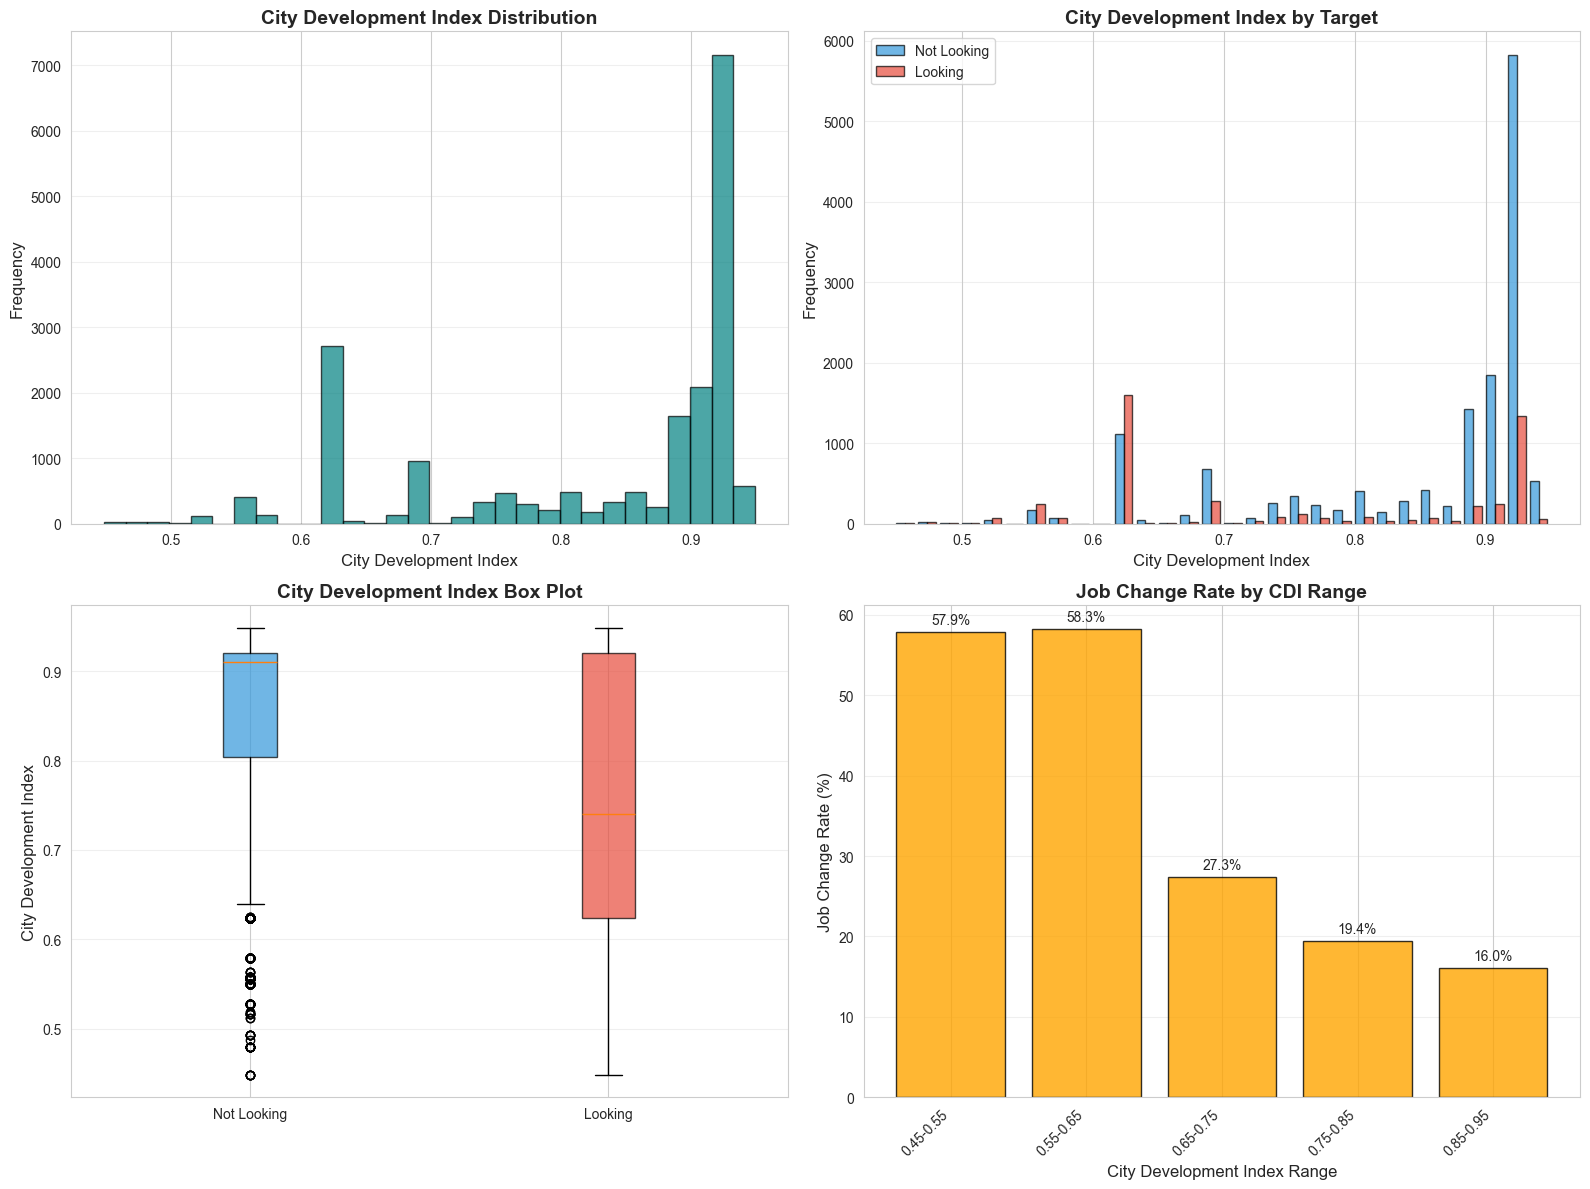

In [14]:
# Q4: City Development Index vs Job Change
cdi_col = get_column_by_name(train_data, train_headers, 'city_development_index')
cdi_numeric = convert_to_numeric(cdi_col)
target_col = get_column_by_name(train_data, train_headers, 'target')
target_numeric = convert_to_numeric(target_col)
valid_mask = ~(np.isnan(cdi_numeric) | np.isnan(target_numeric))
cdi_valid = cdi_numeric[valid_mask]
target_valid = target_numeric[valid_mask]

# Visualization
fig, axes, cdi_not_looking, cdi_looking = plot_numeric_vs_target(
    cdi_numeric, target_numeric, 'City Development Index', bins=30
)

# Add binned analysis to the 4th subplot
n_bins = 5
bin_edges = np.linspace(np.min(cdi_valid), np.max(cdi_valid), n_bins + 1)
bin_labels = [f'{bin_edges[i]:.2f}-{bin_edges[i+1]:.2f}' for i in range(n_bins)]
cdi_binned = np.digitize(cdi_valid, bin_edges[:-1]) - 1
cdi_binned = np.clip(cdi_binned, 0, n_bins - 1)

bin_rates = []
for i in range(n_bins):
    bin_mask = cdi_binned == i
    if np.sum(bin_mask) > 0:
        rate = np.sum(target_valid[bin_mask] == 1) / np.sum(bin_mask) * 100
        bin_rates.append(rate)
    else:
        bin_rates.append(0)

axes[1, 1].bar(range(n_bins), bin_rates, color='orange', edgecolor='black', alpha=0.8)
axes[1, 1].set_xticks(range(n_bins))
axes[1, 1].set_xticklabels(bin_labels, rotation=45, ha='right')
axes[1, 1].set_xlabel('City Development Index Range', fontsize=12)
axes[1, 1].set_ylabel('Job Change Rate (%)', fontsize=12)
axes[1, 1].set_title('Job Change Rate by CDI Range', fontsize=14, fontweight='bold')
axes[1, 1].grid(axis='y', alpha=0.3)

for i, v in enumerate(bin_rates):
    axes[1, 1].text(i, v + 1, f'{v:.1f}%', ha='center', fontsize=10)

plt.tight_layout()
plt.show()




#### Trả lời:
1. Số lượng nhân viên làm việc ở các thành phố có chỉ số phát triển cao chiếm đa số và hầu như họ không muốn chuyển việc. Thành phố phát triển đi đôi với phúc lợi cao và vì thế nên nhân viên cũng không có nhu cầu tìm kiếm công việc mới
2. Các nhân viên ở thành phố phát triển kém chiếm thiểu số nhưng hơn một nửa đều đang muốn tìm kiếm công việc mới. 
3. Ở biểu đồ boxplot, một nhóm người not looking nhưng lại ở thành phố có chỉ số phát triển kém là outliers của dữ liệu. Ta sẽ xem xét remove outliers để mô hình học được majority pattern hơn

## Question 5: Ảnh hưởng của training hour lên mong muốn chuyển việc?

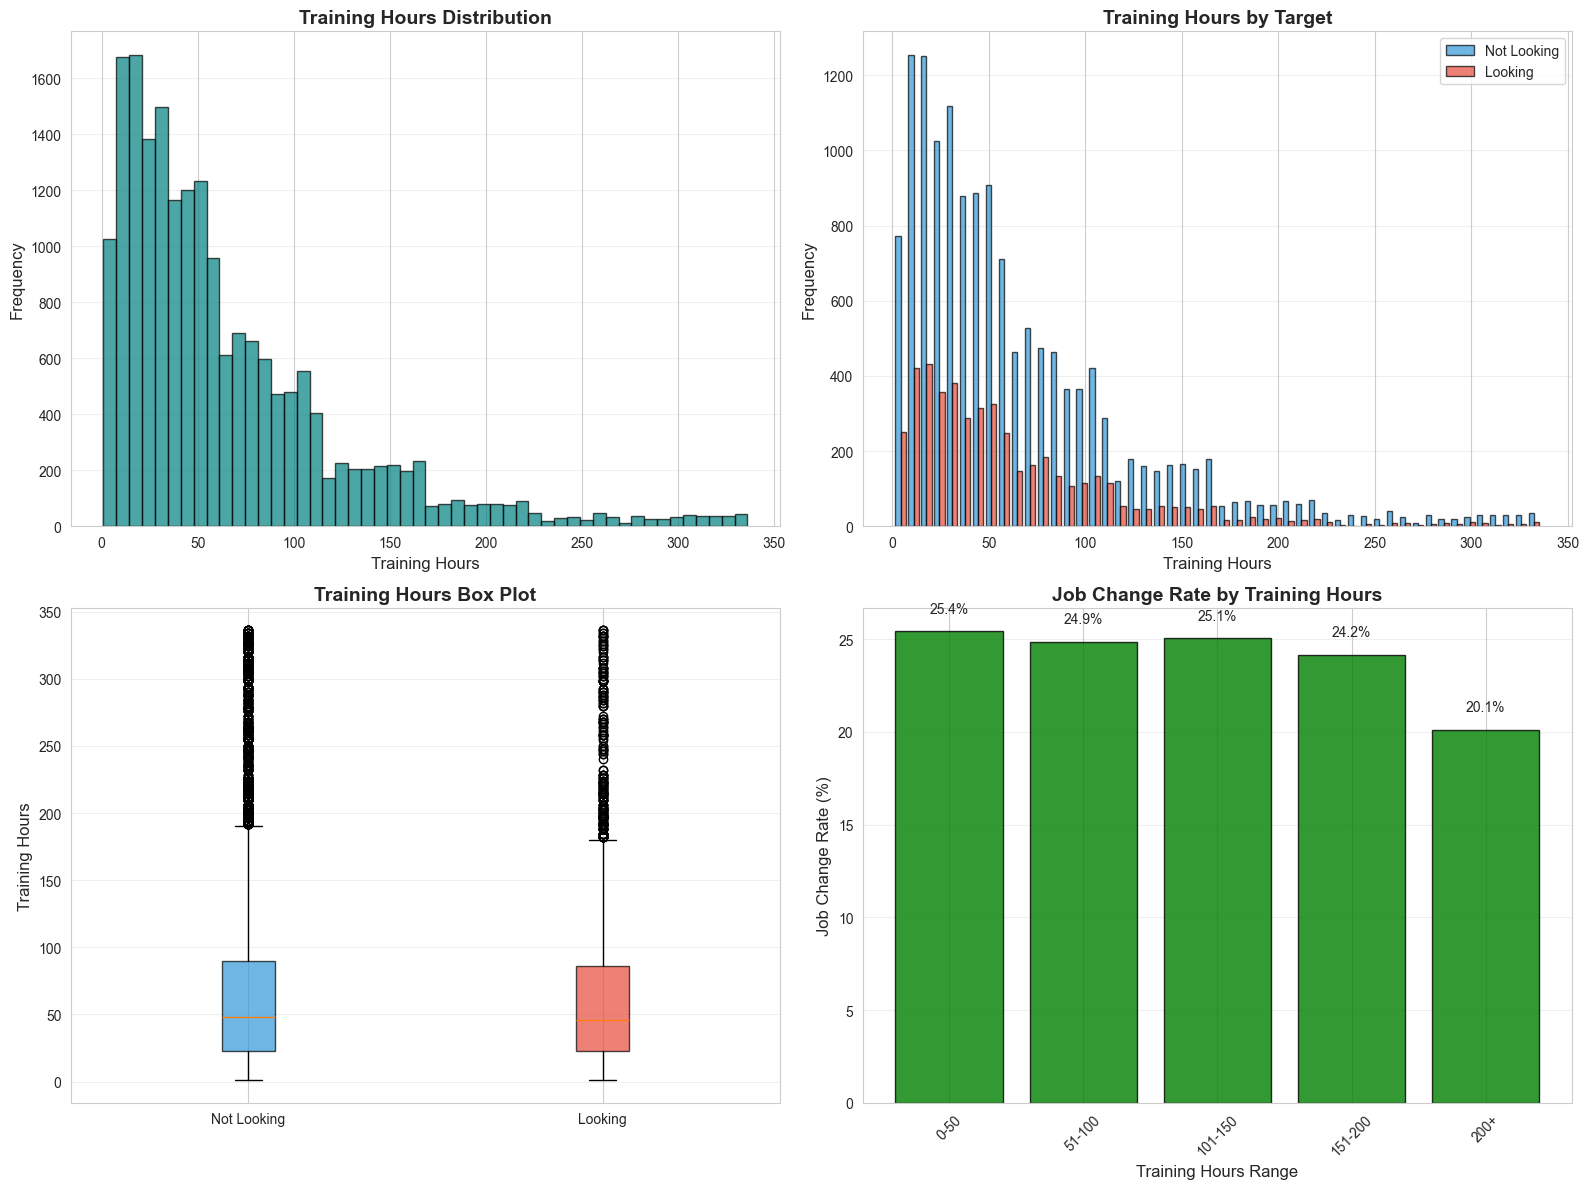

In [15]:
# Q5: Training Hours vs Job Change using NumPy
training_col = get_column_by_name(train_data, train_headers, 'training_hours')
training_numeric = convert_to_numeric(training_col)

# Visualization
fig, axes, training_not_looking, training_looking = plot_numeric_vs_target(
    training_numeric, target_numeric, 'Training Hours', bins=50
)

# Binned analysis
bin_edges = [0, 50, 100, 150, 200]
bin_labels = ['0-50', '51-100', '101-150', '151-200', '200+']
training_binned = np.digitize(training_numeric, bin_edges) - 1
training_binned = np.clip(training_binned, 0, 4)

bin_rates = [np.sum(target_numeric[training_binned == i] == 1) / np.sum(training_binned == i) * 100 
             if np.sum(training_binned == i) > 0 else 0 for i in range(5)]

axes[1, 1].bar(range(5), bin_rates, color='green', edgecolor='black', alpha=0.8)
axes[1, 1].set_xticks(range(5))
axes[1, 1].set_xticklabels(bin_labels, rotation=45)
axes[1, 1].set_xlabel('Training Hours Range', fontsize=12)
axes[1, 1].set_ylabel('Job Change Rate (%)', fontsize=12)
axes[1, 1].set_title('Job Change Rate by Training Hours', fontsize=14, fontweight='bold')
axes[1, 1].grid(axis='y', alpha=0.3)

for i, v in enumerate(bin_rates):
    axes[1, 1].text(i, v + 1, f'{v:.1f}%', ha='center', fontsize=10)

plt.tight_layout()
plt.show()

#### Trả lời:
1. Từ 0 đến 200 giờ: Tỷ lệ muốn chuyển việc gần như đi ngang, dao động cực nhỏ quanh mức 24% - 25% (cụ thể là 25.4%, 24.9%, 25.1%, 24.2%). Điều này có nghĩa là: Dù ứng viên đã hoàn thành 10 giờ training hay 150 giờ training, xác suất họ muốn nhảy việc là như nhau. Việc đào tạo nhiều hay ít thời gian không quan trọng.
2. Vì thế nên training hours không phải là một feature dự báo tốt **Quan trọng**

## Question 6: Quy mô và loại hình công ty có ảnh hưởng lớn không?

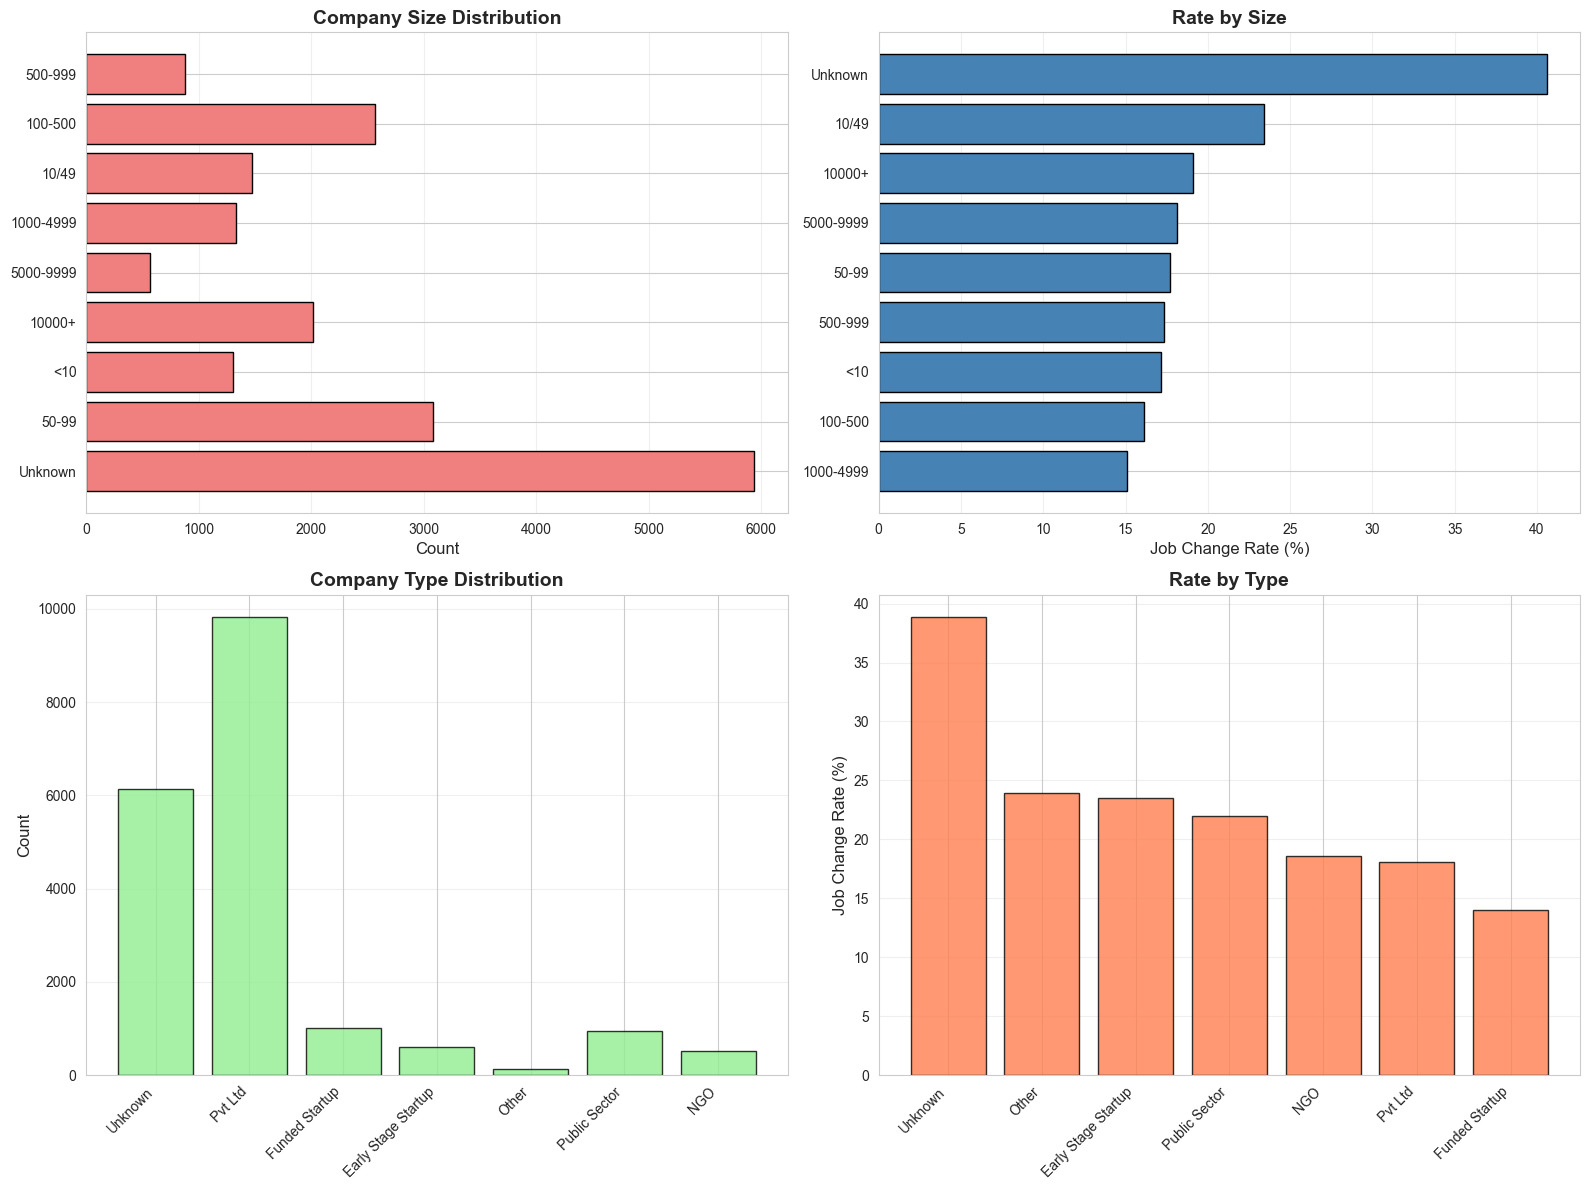

In [16]:
# Q6: Company Size & Type vs Job Change 
size_stats = analyze_categorical_vs_target(train_data, train_headers, 'company_size')
type_stats = analyze_categorical_vs_target(train_data, train_headers, 'company_type')
plot_company_analysis(size_stats, type_stats)


#### Trả lời:
1. Early Stage Startup: Có tỷ lệ nhân sự muốn ra đi rất cao (khoảng 23-24%). Điều này dễ hiểu vì giai đoạn này rủi ro cao
2. Funded Startup (Startup đã được rót vốn): Lại là nơi có tỷ lệ nhân sự muốn đổi việc THẤP NHẤT trong tất cả các loại hình (chỉ khoảng 14%).
3. Công ty tư nhân (Pvt Ltd): Chiếm số lượng đông đảo nhất và có độ ổn định khá cao (tỷ lệ đổi việc khoảng 18%).


## Question 7: Các nhóm giới tính có tỉ lệ nhảy việc như thế nào?

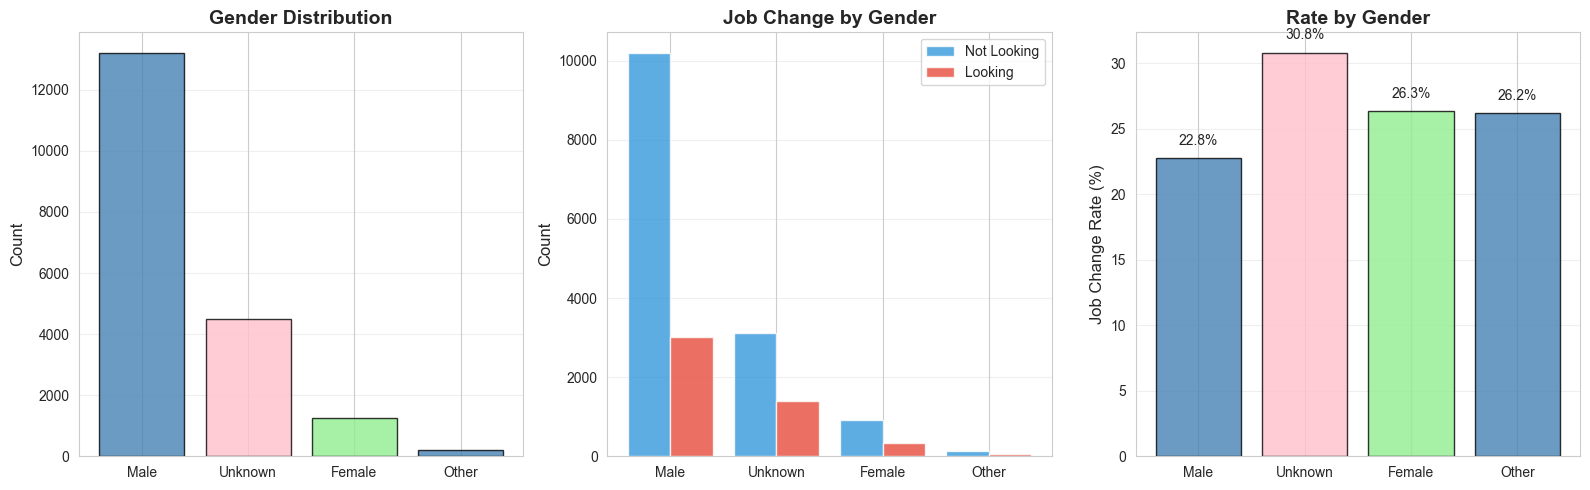

In [17]:
# Q8: Gender vs Job Change 
gender_stats = analyze_categorical_vs_target(train_data, train_headers, 'gender')
plot_gender_analysis(gender_stats)



#### Trả lời:
1. Hai nhóm Unknown và Other có tỉ lệ chuyển việc rất cao, khi dữ liệu bị thiếu hoặc ứng viên không cung cấp thông tin rõ ràng, xu hướng bất ổn định của họ thường cao nhất.
3. Mất cân bằng nghiêm trọng về nguồn nhân lực khi tỉ lệ nhân viên Nam rất đông so với phần còn lại
2. Nam giới có xu hướng ổn định công việc hơn Nữ giới

## Question 8: Liệu thành phố có ảnh hưởng đến tỉ lệ chuyển việc?

#### Trả lời:
1. Dataset có tới **123 unique cities** - quá nhiều để dùng one-hot encoding (sẽ tạo 123 features mới!)
2. Các thành phố lớn (city_103, city_21, city_16) có số lượng ứng viên rất cao nhưng job change rate khác nhau
3. **Giải pháp tốt nhất**: Loại bỏ cột `city` và chỉ giữ `city_development_index` vì:
   - CDI đã capture được thông tin về mức độ phát triển của thành phố
   - CDI có correlation mạnh với target (-0.31)

Total unique cities: 123


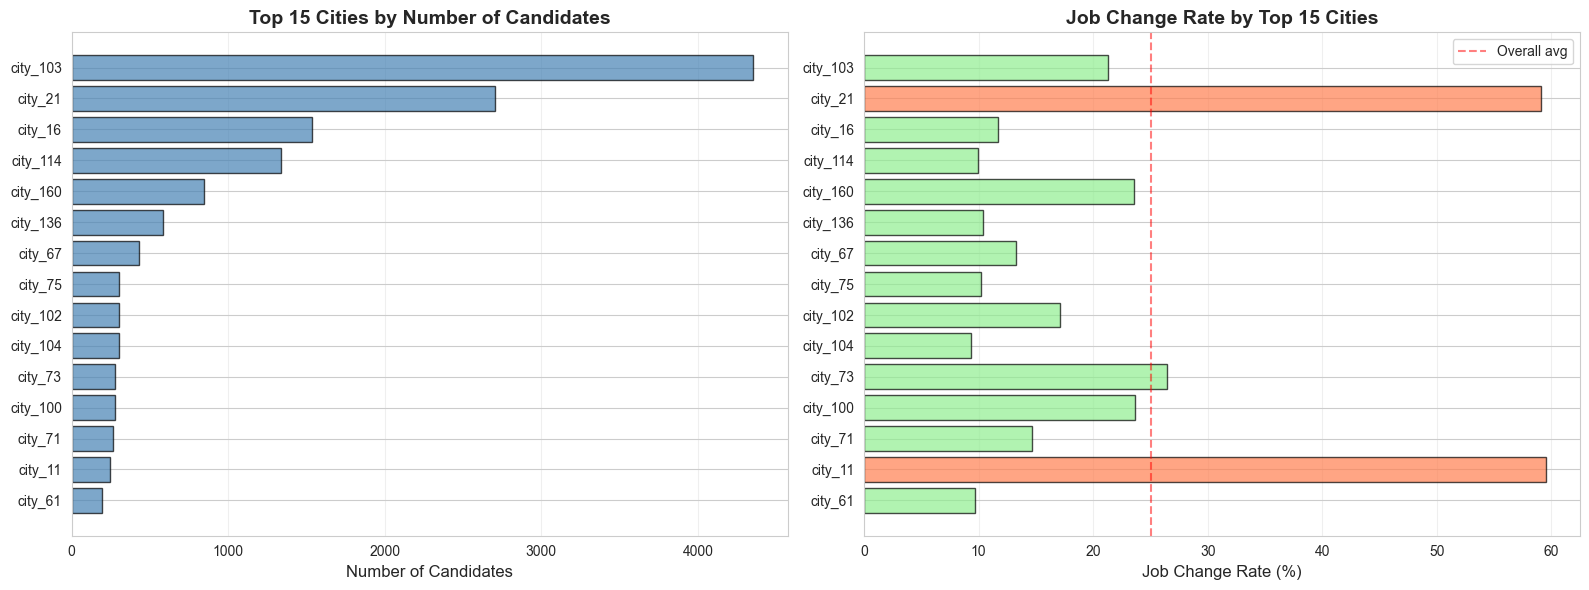

In [18]:
# Q9: City vs Job Change 
city_stats = analyze_categorical_vs_target(train_data, train_headers, 'city')
city_sorted = sorted(city_stats.items(), key=lambda x: x[1]['count'], reverse=True)
top_cities = city_sorted[:20]  # Top 20 cities

print(f"Total unique cities: {len(city_stats)}")
# Visualization - Top cities
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
# Plot 1: Top 15 cities by count
top_15 = top_cities[:15]
cities_names = [c[0] for c in top_15]
cities_counts = [c[1]['count'] for c in top_15]
cities_pct = [c[1]['percentage'] for c in top_15]

axes[0].barh(range(len(cities_names)), cities_counts, color='steelblue', alpha=0.7, edgecolor='black')
axes[0].set_yticks(range(len(cities_names)))
axes[0].set_yticklabels(cities_names)
axes[0].set_xlabel('Number of Candidates', fontsize=12)
axes[0].set_title('Top 15 Cities by Number of Candidates', fontsize=14, fontweight='bold')
axes[0].grid(axis='x', alpha=0.3)
axes[0].invert_yaxis()

# Plot 2: Job change rate by top 15 cities
colors = ['coral' if pct > 30 else 'lightgreen' for pct in cities_pct]
axes[1].barh(range(len(cities_names)), cities_pct, color=colors, alpha=0.7, edgecolor='black')
axes[1].set_yticks(range(len(cities_names)))
axes[1].set_yticklabels(cities_names)
axes[1].set_xlabel('Job Change Rate (%)', fontsize=12)
axes[1].set_title('Job Change Rate by Top 15 Cities', fontsize=14, fontweight='bold')
axes[1].grid(axis='x', alpha=0.3)
axes[1].invert_yaxis()
axes[1].axvline(x=25, color='red', linestyle='--', alpha=0.5, label='Overall avg')
axes[1].legend()


plt.tight_layout()
plt.show()



 1. Có 2 thành phố có tỉ lệ người đi làm muốn tìm kiếm công việc cao bất thường

## Question 9: Phân tích tương quan giữa các features với Target.

Correlation with Target Variable:
city_development_index        :  -0.3416
training_hours                :  -0.0216
city                          :   0.2203
gender                        :  -0.0679
relevent_experience           :  -0.1284
enrolled_university           :   0.1031
education_level               :  -0.0315
major_discipline              :  -0.0055
experience                    :  -0.0060
company_size                  :  -0.1249
company_type                  :  -0.1661
last_new_job                  :  -0.0187


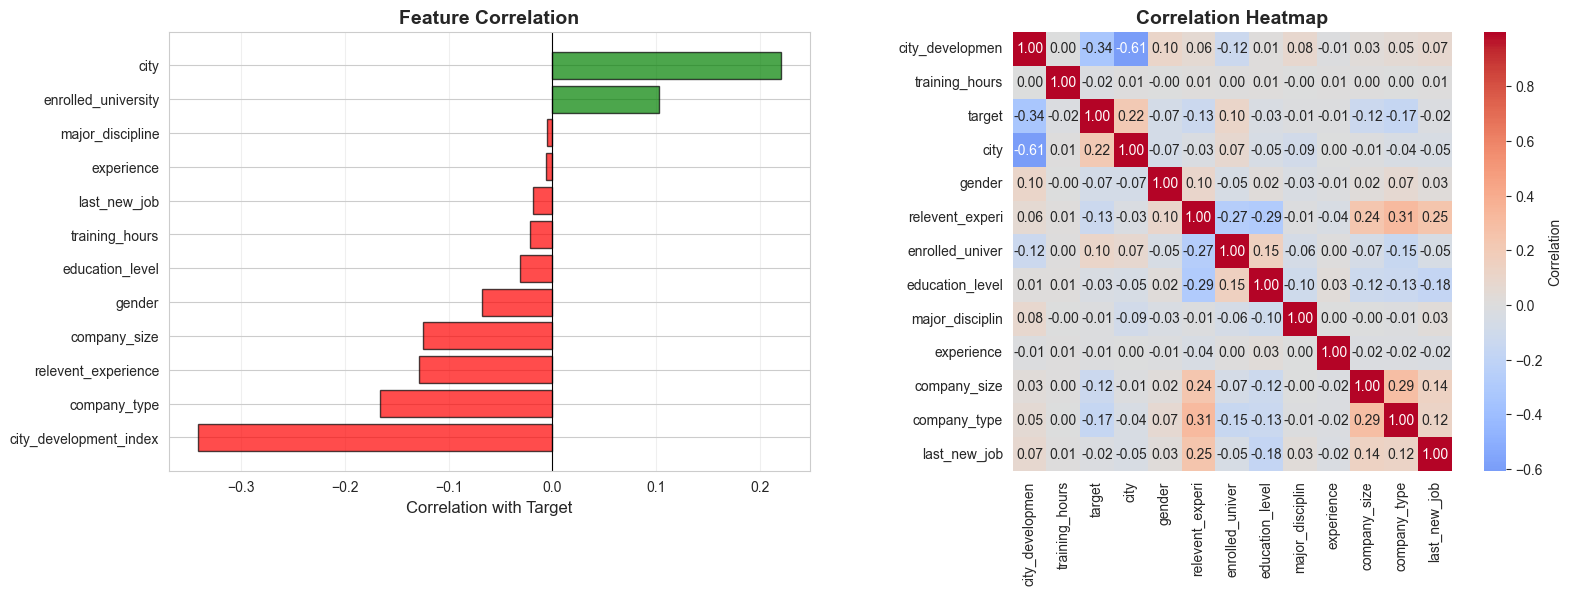

In [19]:
# Q10: Correlation Analysis 
def encode_categorical(column):
    """Label encode a categorical column"""
    unique_vals = list(set([v for v in column if v != '' and v is not None]))
    encoding_map = {val: idx for idx, val in enumerate(unique_vals)}
    encoding_map[''] = -1  # For missing values
    encoding_map[None] = -1
    
    encoded = np.array([encoding_map.get(v, -1) for v in column], dtype=float)
    encoded[encoded == -1] = np.nan
    return encoded

categorical_cols = ['city', 'gender', 'relevent_experience', 'enrolled_university',
                    'education_level', 'major_discipline', 'experience', 'company_size',
                    'company_type', 'last_new_job']

#numerical columns
cdi_col = convert_to_numeric(get_column_by_name(train_data, train_headers, 'city_development_index'))
training_col = convert_to_numeric(get_column_by_name(train_data, train_headers, 'training_hours'))
target_col = convert_to_numeric(get_column_by_name(train_data, train_headers, 'target'))

#correlation data matrix
corr_data = [cdi_col, training_col, target_col]
corr_names = ['city_development_index', 'training_hours', 'target']

# Add encoded categorical columns
for col_name in categorical_cols:
    if col_name in train_headers:
        col_data = get_column_by_name(train_data, train_headers, col_name)
        encoded = encode_categorical(col_data)
        corr_data.append(encoded)
        corr_names.append(col_name + '_enc')
corr_matrix_data = np.column_stack(corr_data)
def nancorr(x, y):
    mask = ~(np.isnan(x) | np.isnan(y))
    if np.sum(mask) < 2:
        return 0.0
    x_valid = x[mask]
    y_valid = y[mask]
    
    x_mean = np.mean(x_valid)
    y_mean = np.mean(y_valid)
    x_std = np.std(x_valid, ddof=1)
    y_std = np.std(y_valid, ddof=1)
    
    if x_std == 0 or y_std == 0:
        return 0.0
    
    return np.mean((x_valid - x_mean) * (y_valid - y_mean)) / (x_std * y_std)

n_features = len(corr_names)
corr_matrix = np.zeros((n_features, n_features))

for i in range(n_features):
    for j in range(n_features):
        corr_matrix[i, j] = nancorr(corr_data[i], corr_data[j])

# Get correlations with target
target_idx = corr_names.index('target')
target_correlations = corr_matrix[:, target_idx]

print("Correlation with Target Variable:")
print("="*60)
for i, name in enumerate(corr_names):
    if name != 'target':
        display_name = name.replace('_enc', '')
        print(f"{display_name:<30}: {target_correlations[i]:>8.4f}")

# Visualization
plot_correlation_analysis(corr_names, target_correlations, corr_matrix, target_idx)



#### Trả lời:
1. **City Development Index** có correlation âm mạnh với target - người ở thành phố phát triển ít chuyển việc hơn
2. **Relevant Experience** có correlation dương - người có kinh nghiệm liên quan có xu hướng chuyển việc nhiều hơn
3. **Training Hours** có correlation rất yếu - không phải yếu tố quan trọng
4. Các feature về company (size, type) và education cũng có correlation đáng kể

**Correlation matrix này chỉ mang tính đánh giá sơ bộ vì các feature categorical không có thứ tự và có thứ tự đều sử dụng label encoding giả định thứ tự để cho biết mức độ liên quan tổng quát thôi**

## Tổng kết

#### Các nhóm features sau đây ảnh hưởng mạnh lên target 
- **`city_development_index`**: Correlation tương đối cao. Thành phố phát triển → ít chuyển việc
- **`relevent_experience`**: Có kinh nghiệm → ít chuyển việc 
- **`enrolled_university`**: Đang học full-time → xu hướng chuyển việc cao 

#### Ảnh hưởng tốt
- **`experience`**: Kinh nghiệm cao → ít chuyển việc. Nhóm <5 năm có tỉ lệ cao nhất
- **`education_level`**: Graduate có tỉ lệ cao nhất, PhD/Primary School thấp nhất
- **`last_new_job`**: Never/1 năm → muốn chuyển. >4 năm → ổn định

#### Ảnh hưởng trung bình
- **`company_size`**
- **`company_type`**
- **`training_hours`**

#### Ảnh hưởng kém
- **`major_discipline`**: Tất cả chuyên ngành đều trong khoảng 21-27%, không khác biệt lớn
- **`gender`**: Male có số lượng lớn nhưng tỉ lệ tương đương Female. Unknown/Other có tỉ lệ cao nhưng thiểu số

#### Đặc biệt feature city mặc dù có rất nhiều thành phố nhưng có 2 mã thành phố ảnh hưởng rất nhiều lên target values
- **`city`**: 123 unique values - quá nhiều cho one-hot. Nhưng có tín hiệu mạnh (một số thành phố >60%, một số <10%)

### 2. Preprocessing Strategy

**Numeric Features - Standardization:**
- `city_development_index`: Z-score normalization 
- `training_hours`: Z-score normalization (phân phối lệch phải)

**Categorical - Binary Encoding:**
- `relevent_experience`: 0/1 encoding (Has relevant experience = 1, No = 0)

**Categorical - Ordinal Encoding:**
- `experience`: 5 bins theo thứ tự (<1→1→2-5→6-15→>15)
- `last_new_job`: 6 levels theo thứ tự (never→1→2→3→4→>4)
- `company_size`: 8 levels theo thứ tự (<10→10/49→50-99→100-500→...→10000+)

**Categorical - One-Hot Encoding:**
- `enrolled_university`: 3 dummies (Full time, Part time, No enrollment)
- `education_level`: 5 dummies (Graduate, Masters, High School, Phd, Primary School)
- `company_type`: 6 dummies (Pvt Ltd, Funded Startup, Public Sector, NGO, ...)
- `major_discipline`: 6 dummies (STEM, Business, Arts, Humanities, No Major, Other)

**Categorical - Label Encoding:**
- `gender`: 3 classes (Male=0, Female=1, Other/Unknown=2 - gộp chung)

**Features bị loại bỏ:**
- `city`: DROP (123 unique values, thay bằng city_development_index)
- `enrollee_id`: DROP (ID không có ý nghĩa dự đoán)

**Feature Engineering:**
- Interaction: `experience × relevent_experience`
- Interaction: `company_size × last_new_job`
- Missing flags: 4 binary indicators cho gender, major_discipline, company_size, company_type

**Kết quả:** 14 features gốc → ~40 features sau preprocessing

### 3. Key Insights cho Modeling

1. **Class Imbalance**: 75% không chuyển vs 25% chuyển → Cần xử lý (SMOTE, class_weight)
2. **Feature Engineering**: 
   - Tạo interaction: `experience × relevent_experience`
   - Tạo interaction: `company_size × last_new_job`
   - Missing indicators cho gender, major_discipline, company_size/type
3. **Target Encoding cho city**: Không khả thi với NumPy-only constraint → **Drop `city`**, giữ `city_development_index`
## Tiến hành preprocessing qua notebook 02_preprocessing.ipynb